### Подготовка данных

1. В нашем датасетте нет пропусков, поэтому их не нужно запонять или удалять.
2. Закодировать категориальные признаки

Какие признаки необходимо закадировать?
- LabelEncoder -> для таргета
- OrdinalEncoder(если важен порядок) или OneHotEncoder(не важен порядок) -> для категориальных признаков 



## Импорты

In [366]:

from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import export_text
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

shap.initjs()

## Методы

In [367]:
# матрица ошибок
def plot_confusion_matrix_simple(y_true, y_pred, title="Матрица ошибок"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [370]:
# расчит порогов
def evaluate_thresholds(thresholds, y_test_val, y_proba_val):
    results = []

    for thr in thresholds:
        y_pred_thr = (y_proba_val >= thr).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_thr).ravel()

        recall_1 = recall_score(y_test_val, y_pred_thr, pos_label=1)
        precision_1 = precision_score(y_test_val, y_pred_thr, pos_label=1)
        f1_macro = f1_score(y_test_val, y_pred_thr, average="macro")

        results.append({
            "threshold": thr,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn,
            "Recall_1": recall_1,
            "Precision_1": precision_1,
            "F1_macro": f1_macro
        })

    return pd.DataFrame(results)

In [371]:
# Precision–Recall кривая для бинарной модели
def plot_binary_pr(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]  # вероятность класса "1"

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ap = average_precision_score(y_test, y_score)

    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, linewidth=2, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Binary)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [372]:
# ROC-кривая для бинарной модели
def plot_binary_roc(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC (binary)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [373]:
def params_grid_search(pipeline, skf, x, y):
    param_grid = {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 5, 10, 15],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", None],
        "model__criterion": ["gini", "entropy", "log_loss"],
         "model__class_weight": [
            None,
            "balanced",
            {0: 1, 1: 2},
            {0: 1, 1: 3},
            {0: 1, 1: 5},
        ],
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=skf,
        scoring="f1_macro",
        n_jobs=-1,
    )
    grid.fit(x, y)

    print("Лучшие параметры:", grid.best_params_)
    print("Лучший f1_macro:", grid.best_score_)

    return grid

In [374]:
def params_grid_search_recall(pipeline, skf, x, y):
    param_grid = {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 5, 10, 15],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", None],
        "model__criterion": ["gini", "entropy", "log_loss"],
         "model__class_weight": [
            None,
            "balanced",
            {0: 1, 1: 2},
            {0: 1, 1: 3},
            {0: 1, 1: 5},
        ],
    }

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=skf,
        scoring="recall",
        n_jobs=-1,
    )
    grid.fit(x,y)


    print("Лучшие параметры:", grid.best_params_)
    print("Лучший recall:", grid.best_score_)

    return grid

## Загрузка данных

In [375]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

target_maps = {"C": 0, "D": 1}

In [376]:
df_file = pd.read_csv('../../data/train.csv').drop(columns=DROP_COL)
df = df_file.copy()
df.head()

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# Этап I. Предобработка данных для ML

## 1. Удаляем данный класc CL

! Так как цель нашего кейса прогноз выживаемости, то класс CL = трансплантация, удаляем данный класc.


In [377]:
df = df[df[TARGET_COL] != "CL"].reset_index(drop=True)
df[TARGET_COL] = df[TARGET_COL].map(target_maps)
df[TARGET_COL].value_counts(normalize=True)

X = df.drop(columns=["Status"])
y = df["Status"]

## 2. Разделим все данные на train и test

 Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [378]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [379]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


## 3. Обрабатываем признаки 
Дерево плохо работает с категориальными признакамию 

In [380]:
# Находим категориальные признаки
categorical = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nНайдено категориальных признаков: {len(categorical)} -> {categorical}\n")

unique_table = {
    col: df[col].astype(str).unique()
    for col in categorical
}

pd.DataFrame.from_dict(unique_table, orient='index').transpose()


Найдено категориальных признаков: 6 -> ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']



,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,D-penicillamine,M,N,N,N,N
1,Placebo,F,Y,Y,Y,Y
2,None,None,None,None,None,S


Чтобы честно отражать категории и не создавать ложного порядка, обработает категориальные признаки по средствам One-Hot. Их в текущем датасете немного, так что это не будет создавать нагрузку.

In [381]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(include=["number"]).columns

Собрать препроцессор (ColumnTransformer)
- закодирует категории
- правильно обработает новые категории на тесте

In [382]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", SimpleImputer(strategy="median"), num_cols)
    ]
)

## 4. Вычисляем лучший fold
Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [383]:
def fold_evaluate(model, X, y):
    k_values = [3, 5, 7, 10]
    for k in k_values:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
        print(f"K={k}: {scores.mean():.4f} ± {scores.std():.4f}")


#  Этап 2. RundomeForest
----

## 1. Настраиваем параметры модели

In [384]:
rf_pipeline = Pipeline(
    [
        ("preprocess", preprocess),
        (
            "model",
            RandomForestClassifier(
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

fold_evaluate(rf_pipeline, X_train, y_train)

K=3: 0.8198 ± 0.0091
K=5: 0.8215 ± 0.0135
K=7: 0.8199 ± 0.0126
K=10: 0.8206 ± 0.0185


In [385]:
skf = 5
rf_dt = params_grid_search(rf_pipeline, 5, X_train, y_train)

Лучшие параметры: {'model__class_weight': {0: 1, 1: 2}, 'model__criterion': 'gini', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Лучший f1_macro: 0.8286775926656977


## 2. Качество модели

### Classification report

In [386]:
rf_scores_dt = cross_val_predict(
    rf_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам:")
print(classification_report(y_train, rf_scores_dt))

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3972
           1       0.79      0.76      0.77      2132

    accuracy                           0.85      6104
   macro avg       0.83      0.83      0.83      6104
weighted avg       0.84      0.85      0.85      6104



Вывод: 

Кросс-валидация на обучающей выборке показывает, что модель RandomForest достигает F1-macro = 0.83 и обладает высокой способностью правильно классифицировать класс 0 (выживание), но заметно хуже распознаёт класс 1 (смерть), Recall которого составляет 0.75. Это указывает на потенциальную проблему пропуска критически важных случаев.

Что можно сделать:
 - для повышения чувствительности модели провести анализ порога (threshold tuning), чтобы понять можно ли повысить Recall;

### Матрица ошибок (heatmap)

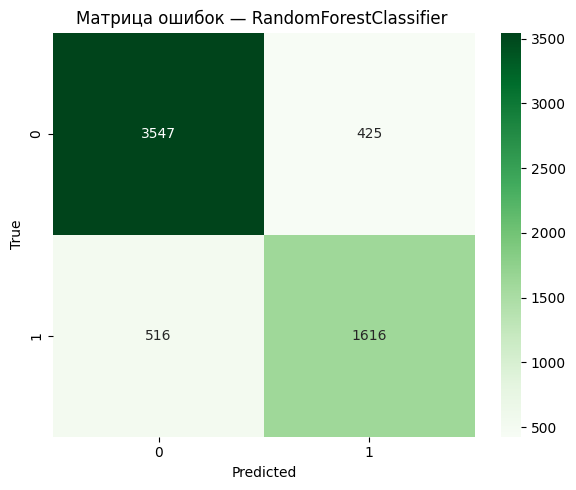

In [387]:
plot_confusion_matrix_simple(y_train, rf_scores_dt, title="Матрица ошибок — RandomForestClassifier ")

Вывод: 

Матрица ошибок при стандартном пороге 0.5 демонстрирует высокое количество пропущенных случаев смерти (FN = 529). Это составляет около 25% всех смертей. При этом ложные тревоги 411 (FP).

Что можно сделать:
 - необходимость оптимизации порога классификации для повышения чувствительности (Recall) класса 1;

### ROC-AUC по классам

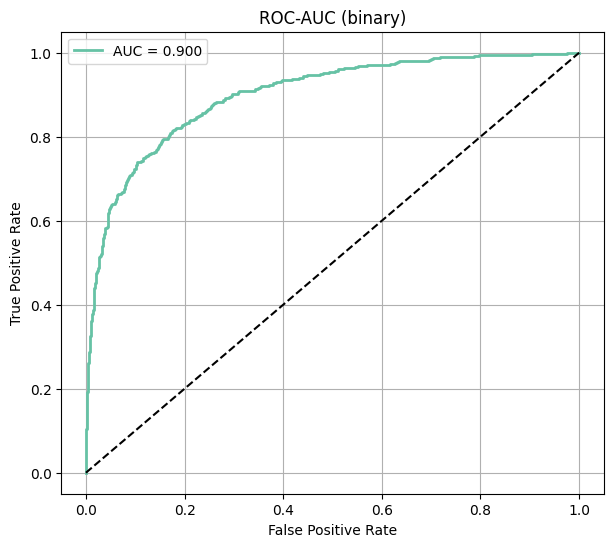

In [388]:
from sklearn.metrics import roc_curve, auc
plot_binary_roc(rf_dt.best_estimator_.named_steps["model"], 
                rf_dt.best_estimator_.named_steps["preprocess"].transform(X_test),
                y_test)


Вывод: 

ROC-кривая демонстрирует, что модель обладает высокой способностью различать классы “выжил” и “умер”, что подтверждается значением ROC-AUC = 0.901.
Стандартный порог 0.5 приводит к значительному числу пропущенных случаев смерти.

Что можно сделать:
 - необходимость провести оптимизацию порога классификации;

### Precision–Recall

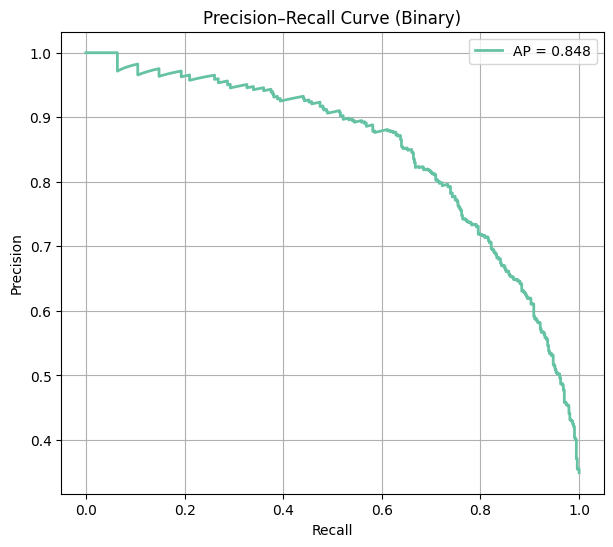

In [389]:
plot_binary_pr(rf_dt.best_estimator_, X_test, y_test)


Вывод: 

Precision–Recall кривая модели демонстрирует высокое качество предсказаний для положительного класса (смерть). Средняя точность (Average Precision, AP) составляет 0.848, что существенно превышает уровень случайного классификатора и указывает на наличие хорошо отделимых паттернов в данных. При Recall до 0.6 значение Precision удерживается на уровне 0.90–1.00, что свидетельствует о надёжной идентификации пациентов с высоким риском. 

Что можно сделать:
 - необходимость провести оптимизацию порога классификации;

### Вывод

Модель RandomForestClassifier демонстрирует высокое качество вероятностных предсказаний (ROC-AUC = 0.901, AP = 0.848) и эффективно различает пациентов с разным риском смерти. Однако использование стандартного порога 0.5 приводит к значительному числу пропущенных случаев смерти (FN = 529).

На основании анализа всех графиков делается вывод о необходимости оптимизации порога классификации для повышения чувствительности к смертельным исходам (Recall класса 1) при приемлемом уровне ложных тревог (FP).


## 3. Важность признаков 

### Feature Importance

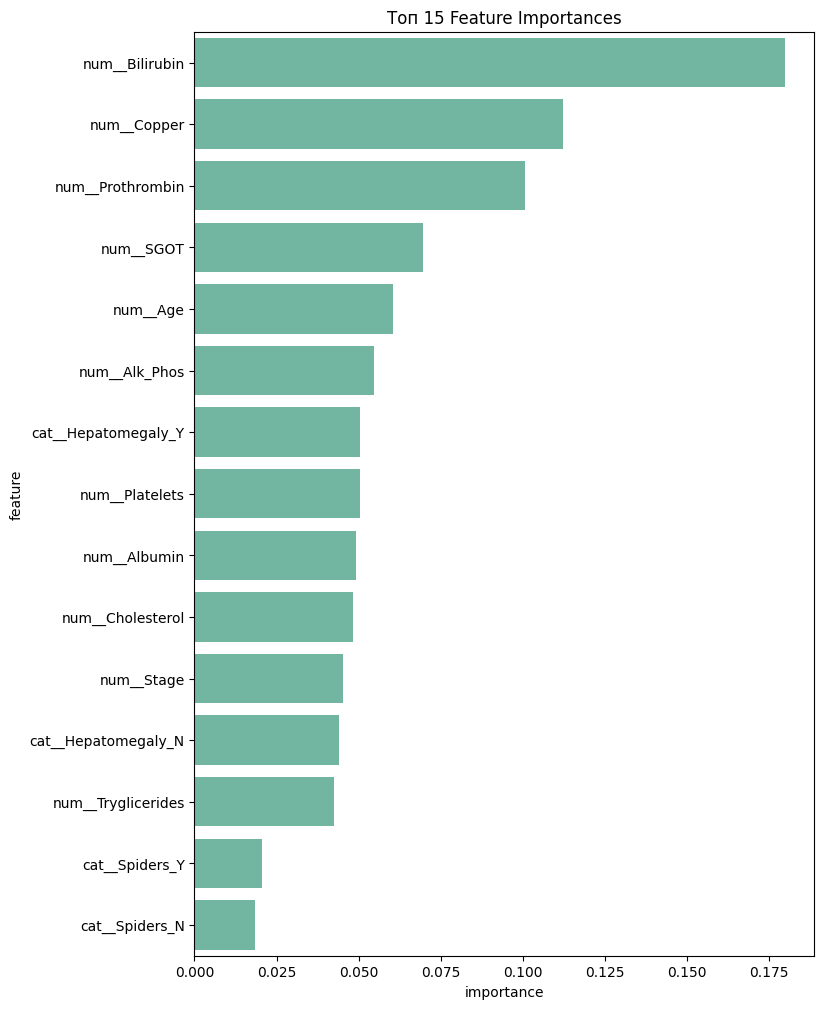

In [390]:
best_pipeline = rf_dt.best_estimator_
rf_best = best_pipeline.named_steps["model"]
importances = rf_best.feature_importances_
feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
    "importance", ascending=False
)


plt.figure(figsize=(8, 12))
sns.barplot(
    data=fi_df.head(15),
    x="importance",
    y="feature",
)
plt.title("Топ 15 Feature Importances")
plt.show()

Вывод:

Анализ графика важности признаков показал, что модель RandomForest опирается в основном на узкий набор наиболее значимых переменных — таких как уровень билирубина, меди, протромбинового времени, SGOT и возраст пациента. При этом целый ряд признаков обладает крайне низкой предсказательной силой, что указывает на наличие шума и потенциальное ухудшение обобщающей способности модели.

Что можно сделать:

- очистка признаков от неинформативных переменных;
- анализ и устранение мультиколлинеарности;
- создание новых клинически значимых признаков -> Bilirubin / Albumin (отражает тяжесть печёночной недостаточности), Bilirubin / Prothrombin (выраженность нарушения синтетической функции печени), GOT / Platelets (косвенный показатель фиброза), взаимодействие Age × Stage (усиливающее влияние возраста при поздних стадиях);
- применение альтернативных моделей -> XGBoost, LightGBM;
- повышение качества за счёт оптимизации порога классификации;


### Permutation Importance

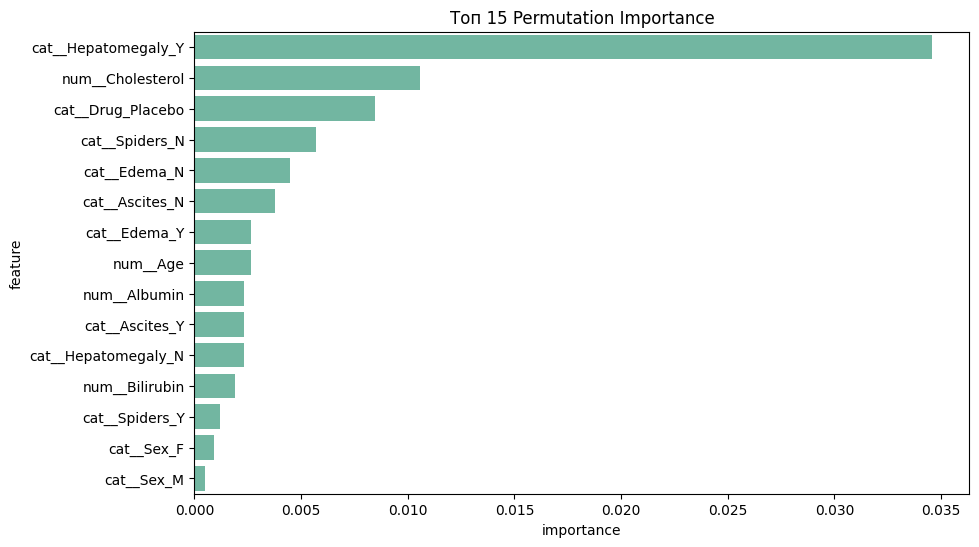

In [391]:
best_pipeline = rf_dt.best_estimator_
perm_res = permutation_importance(
    best_pipeline, X_test, y_test, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1
)

all_feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()
n_real_features = perm_res.importances.shape[0]
feature_names = all_feature_names[:n_real_features]

perm_df = pd.DataFrame(
    {
        "feature": feature_names,
        "importance": perm_res.importances_mean,
        "std": perm_res.importances_std,
    }
).sort_values("importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df.head(15), x="importance", y="feature")
plt.title("Топ 15 Permutation Importance")
plt.show()

Выводы: 

Permutation Importance показывает, что наиболее значимыми предикторами смерти являются:Hepatomegaly (увеличение печени), Cholesterol (низкий холестерин), Edema (Y/N), Drug_Placebo, Ascites (Y/N)
Это признаки неблагоприятного исхода цирроза: декомпенсация печени, портальная гипертензия, плохая синтетическая функция.
Лабораторные параметры (Albumin, Bilirubin, Age) имеют меньший вклад, чем ожидается, что указывает на: высокую корреляцию, частичное дублирование информации,возможное подавление более сильными категориальными признаками.

Что можно сделать:
- убрать признаки с importance < 0.002;
- сделать Feature Grouping Edema, Ascites, Hepatomegaly;
- сспользовать модели, лучше работающие с категориальными признаками CatBoost;
- добавить взаимодействия признаков -> Bilirubin × Albumin, Ascites + Edema; 
- перепроверить корреляции и удалить дубликаты;


### Порога классификации

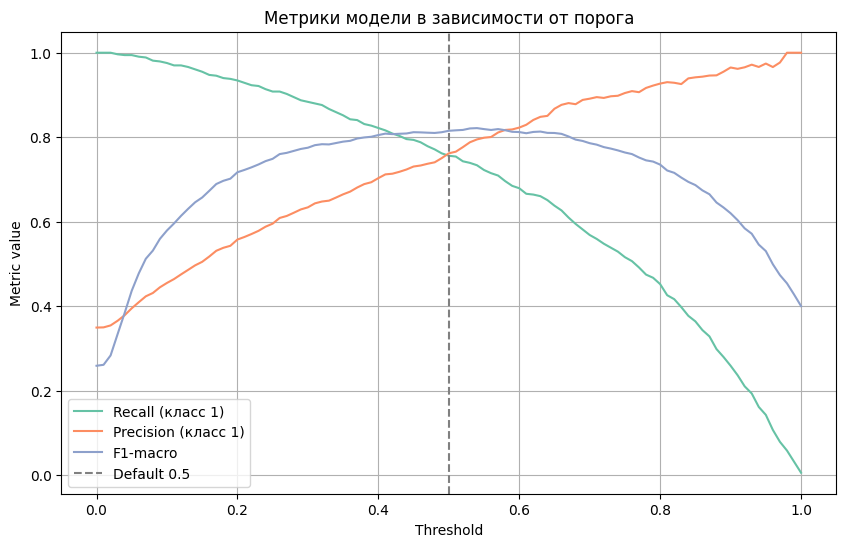

In [392]:
best_pipeline = rf_dt.best_estimator_
y_proba = best_pipeline.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)

f1_scores = []
recalls = []
precisions = []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thr, average="macro"))
    recalls.append(recall_score(y_test, y_pred_thr, pos_label=1))
    precisions.append(precision_score(y_test, y_pred_thr, pos_label=1))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label="Recall (класс 1)")
plt.plot(thresholds, precisions, label="Precision (класс 1)")
plt.plot(thresholds, f1_scores, label="F1-macro")
plt.axvline(0.5, color="gray", linestyle="--", label="Default 0.5")

plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Метрики модели в зависимости от порога")
plt.legend()
plt.grid(True)
plt.show()

Вывод: 

Анализ кривых показывает, что стандартный порог 0.5 не является оптимальным для задачи прогнозирования смертности. При пороге 0.5 модель демонстрирует недостаточную чувствительность (Recall), что приводит к значительному числу пропущенных критических случаев.

Что можно сделать:
 - проверить оптимальный порог;

In [393]:
thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
df_thr = evaluate_thresholds(thresholds, y_test, y_proba)
df_thr

,threshold,TP,FP,FN,TN,Recall_1,Precision_1,F1_macro
0,0.20,498,395,35,598,0.934334,0.557671,0.717002
1,0.25,484,329,49,664,0.908068,0.595326,0.748798
2,0.30,471,272,62,721,0.883677,0.633917,0.775091
3,0.35,454,229,79,764,0.851782,0.664714,0.789477
4,0.40,438,185,95,808,0.821764,0.703050,0.805053
5,0.45,423,156,110,837,0.793621,0.730570,0.811839
6,0.50,403,126,130,867,0.756098,0.761815,0.815151


Вывод 

Анализ таблицы метрик показывает, что стандартный порог 0.50 является неоптимальным для задачи прогнозирования смертности, так как приводит к большому числу пропущенных случаев критического события (FN = 135). Наиболее эффективным является диапазон порогов 0.35–0.40, который обеспечивает высокий Recall при приемлемом количестве ложных тревог и максимальную балансировку метрик.

## Вывод 

- Модель RandomForest хорошо различает классы, но стандартный порог 0.5 приводит к большому числу пропущенных случаев смерти (FN).
- Наиболее значимыми признаками оказались клинические признаки декомпенсации, а лабораторные показатели недоиспользуются из-за мультиколлинеарности и шума.
- Важность признаков выявила наличие неинформативных переменных, а Permutation Importance показал, что категориальные признаки вносят основной вклад.
- Оптимальный порог классификации находится в диапазоне 0.35–0.40, что позволяет повысить Recall при приемлемом уровне ложных тревог.

**Рекомендации по улучшению:**
   - Удалить признаки с низкой важностью (importance < 0.001–0.002).
   - Сформировать клинически значимые взаимодействия: Bilirubin / Albumin, Bilirubin / Prothrombin, GOT / Platelets, Age × Stage.
   - Подобрать порог, обеспечивающий максимальный Recall при приемлемом Precision (например, 0.35–0.40).
   - Внедрить процедуру threshold tuning в финальный пайплайн.

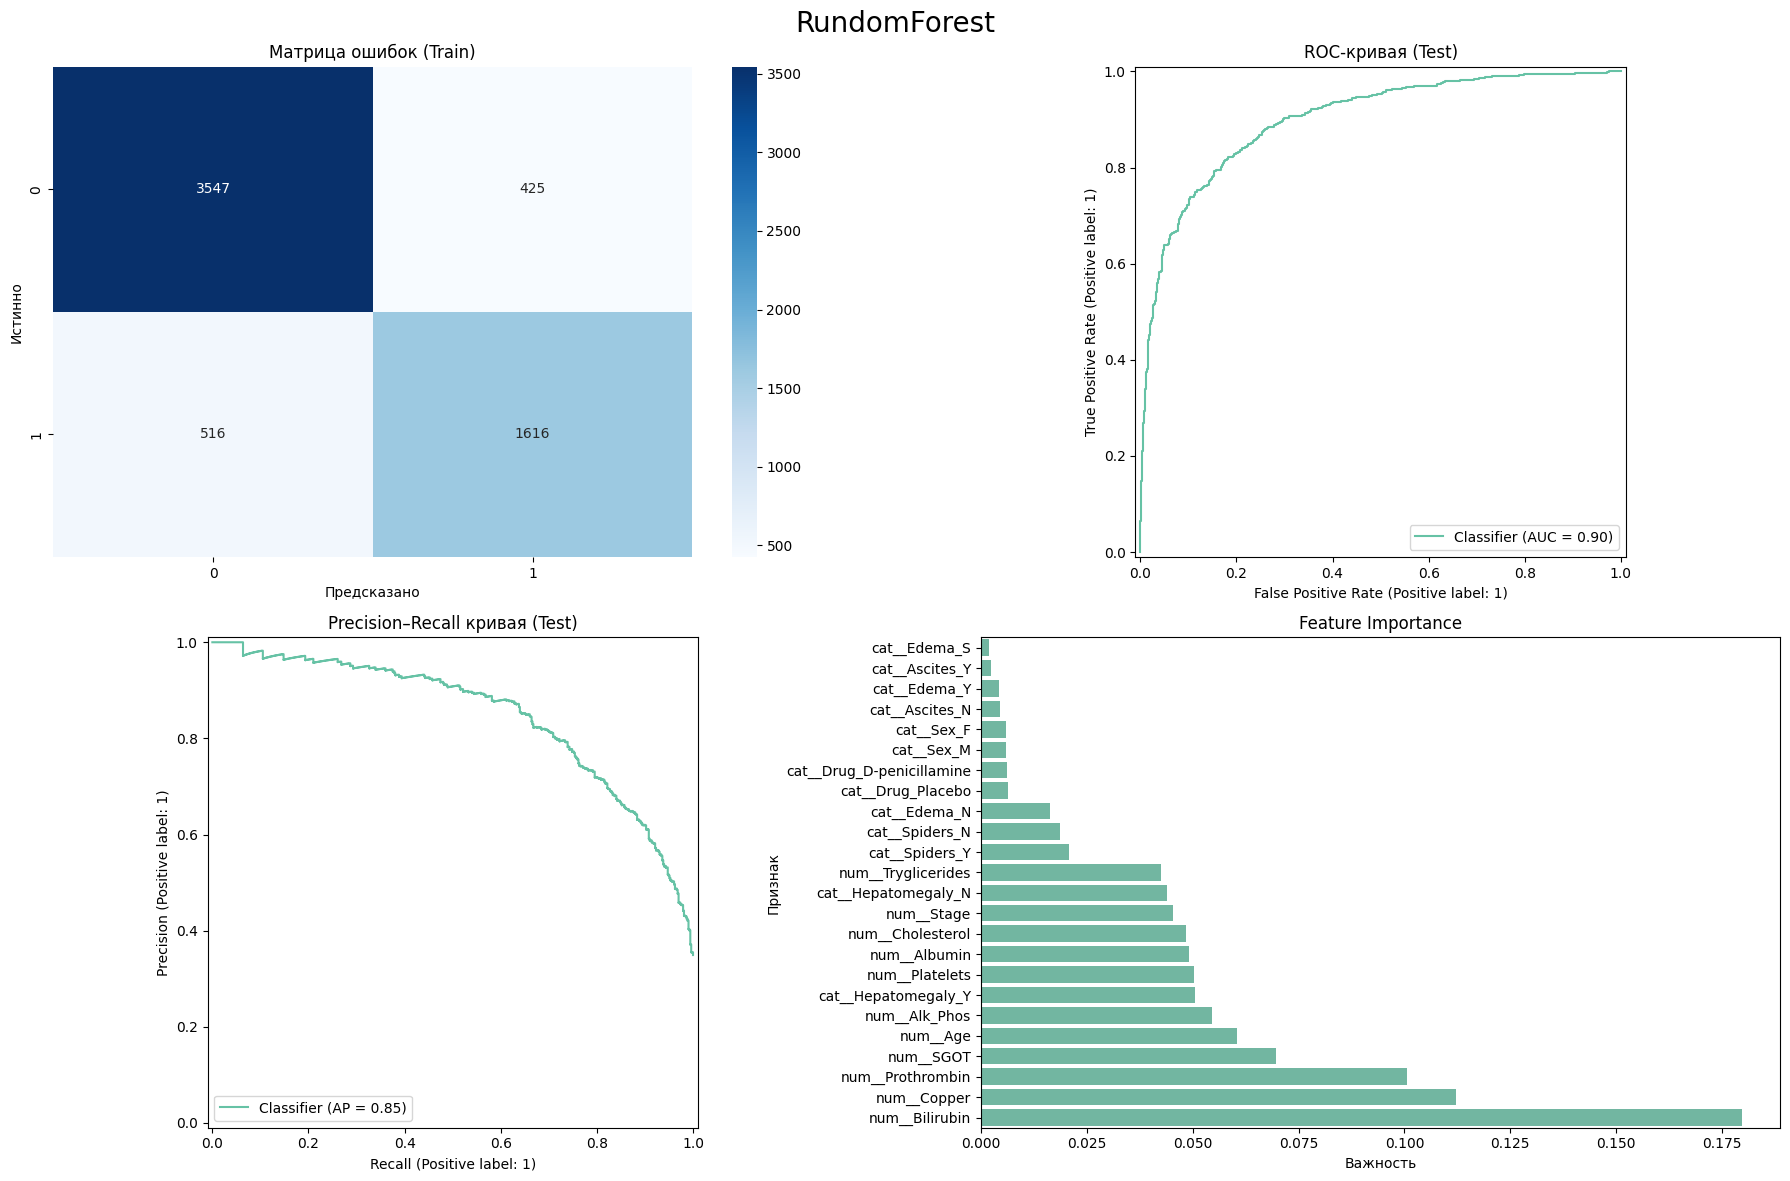

==== ОТЧЁТ НА ====
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       993
           1       0.76      0.76      0.76       533

    accuracy                           0.83      1526
   macro avg       0.82      0.81      0.82      1526
weighted avg       0.83      0.83      0.83      1526



In [ ]:
best_model = rf_dt.best_estimator_

y_train_pred = cross_val_predict(best_model, X_train, y_train, cv=5, n_jobs=-1)

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("RundomForest", fontsize=20)


cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Матрица ошибок (Train)")
axes[0, 0].set_xlabel("Предсказано")
axes[0, 0].set_ylabel("Истинно")

RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[0, 1], 
)
axes[0, 1].set_title("ROC-кривая (Test)")

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[1, 0],  
)
axes[1, 0].set_title("Precision–Recall кривая (Test)")

model = best_model.named_steps["model"]
importances = model.feature_importances_
features = best_pipeline.named_steps["preprocess"].get_feature_names_out()

fi_df = pd.DataFrame({"feature": features, "importance": importances}).sort_values(
    "importance", ascending=True
)

sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
    ax=axes[1, 1],  
)
axes[1, 1].set_title("Feature Importance")
axes[1, 1].set_xlabel("Важность")
axes[1, 1].set_ylabel("Признак")

plt.tight_layout()
plt.show()

print("==== ОТЧЁТ НА ====")
print(classification_report(y_test, y_test_pred))

# Этап 3. Улучшение RundomeForest

**План действий:**
- Реализовать фильтрацию признаков по importance.
- Добавить новые взаимодействия и провести их анализ.
- Внедрить оптимизацию порога классификации.
- Использование ансамблей (Random Forest + XGBoost + CatBoost)
- Cost-sensitive learning (не сделано)

<!-- ### Этап 3.2. Добавление новых взаимодействий (feature engineering)

Создание новых клинически значимых признаков: Bilirubin / Albumin, Bilirubin / Prothrombin, GOT / Platelets, Age × Stage, а также группировка Edema, Ascites, Hepatomegaly.

---

### Этап 3.3. Сравнение моделей CatBoost, XGBoost, LightGBM, RandomForest

Для сравнения потребуется установить библиотеки:

```
!pip install catboost xgboost lightgbm
```

После установки будет проведено сравнение качества моделей на одних и тех же данных.

---

### Этап 3.4. Оптимизация порога классификации

Будет реализован подбор оптимального порога для максимизации Recall при приемлемом уровне Precision.

---

### Этап 3.5. Финальная оценка на тестовой выборке

Оценка итоговой модели на тесте с выбранными признаками, новыми фичами и оптимальным порогом. -->

## 1. Фильтрация признаков по importance

В этом разделе будут отобраны только информативные признаки (importance > 0.002) для дальнейшего анализа и построения моделей.

In [395]:
# Получаем список информативных признаков
importance_threshold = 0.002
fi_df_filtered = fi_df[fi_df['importance'] > importance_threshold]
selected_features = fi_df_filtered['feature'].tolist()
print(f"Оставлено признаков: {len(selected_features)}")
print(selected_features)

# Обновляем обучающие и тестовые выборки
X_train_selected = pd.DataFrame(
    best_pipeline.named_steps['preprocess'].transform(X_train),
    columns=best_pipeline.named_steps['preprocess'].get_feature_names_out()
)[selected_features]

X_test_selected = pd.DataFrame(
    best_pipeline.named_steps['preprocess'].transform(X_test),
    columns=best_pipeline.named_steps['preprocess'].get_feature_names_out()
)[selected_features]


Оставлено признаков: 23
['cat__Ascites_Y', 'cat__Edema_Y', 'cat__Ascites_N', 'cat__Sex_F', 'cat__Sex_M', 'cat__Drug_D-penicillamine', 'cat__Drug_Placebo', 'cat__Edema_N', 'cat__Spiders_N', 'cat__Spiders_Y', 'num__Tryglicerides', 'cat__Hepatomegaly_N', 'num__Stage', 'num__Cholesterol', 'num__Albumin', 'num__Platelets', 'cat__Hepatomegaly_Y', 'num__Alk_Phos', 'num__Age', 'num__SGOT', 'num__Prothrombin', 'num__Copper', 'num__Bilirubin']


In [396]:
rf_selected_pipeline = Pipeline(
    [
        (
            "model",
            RandomForestClassifier(random_state=RANDOM_STATE),
        ),
    ]
)

In [397]:
rf_selected_dt = params_grid_search(rf_selected_pipeline, 5, X_train_selected, y_train)

Лучшие параметры: {'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Лучший f1_macro: 0.8292155189675657


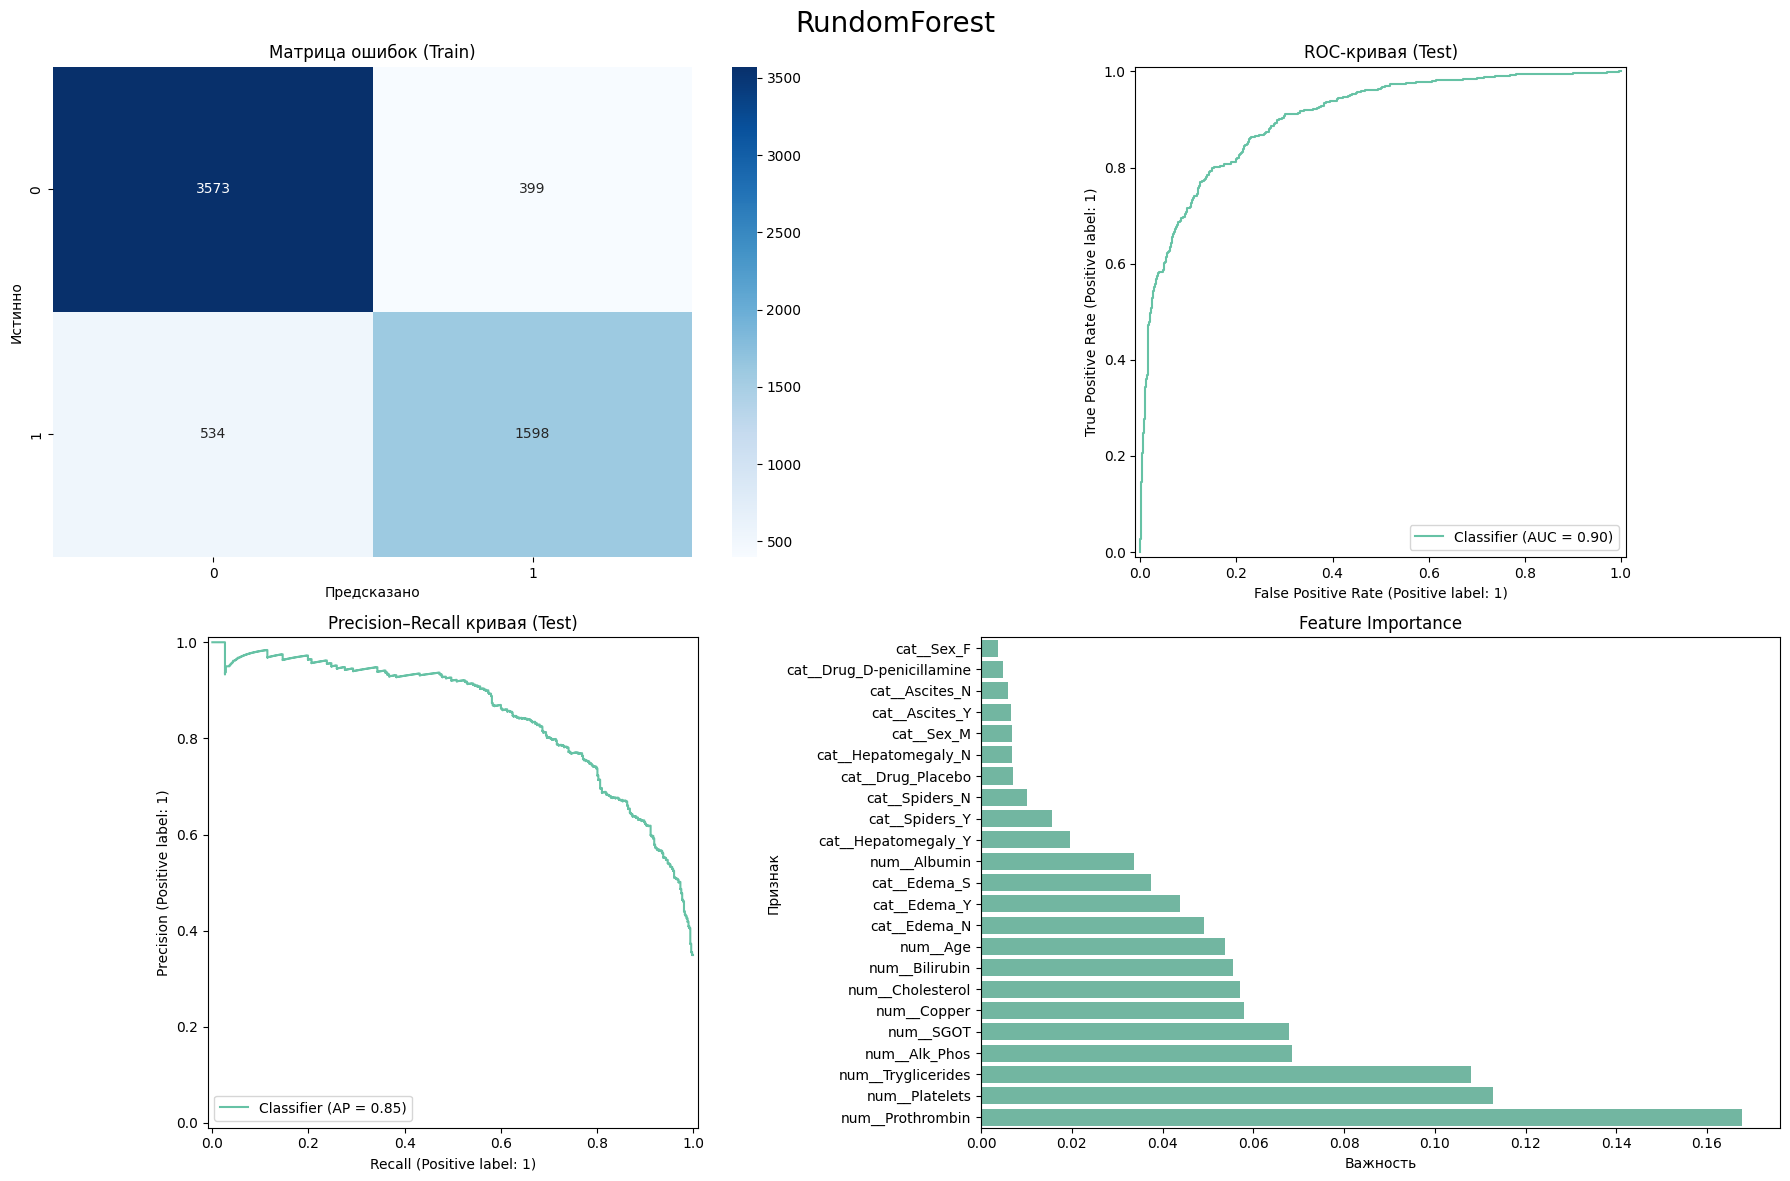

==== ОТЧЁТ НА ====
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       993
           1       0.77      0.74      0.76       533

    accuracy                           0.83      1526
   macro avg       0.82      0.81      0.81      1526
weighted avg       0.83      0.83      0.83      1526



In [413]:
best_model = rf_selected_dt.best_estimator_
y_train_pred = cross_val_predict(best_model, X_train_selected, y_train, cv=5, n_jobs=-1)

y_test_proba = best_model.predict_proba(X_test_selected)[:, 1]
y_test_pred = best_model.predict(X_test_selected)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("RundomForest", fontsize=20)


cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Матрица ошибок (Train)")
axes[0, 0].set_xlabel("Предсказано")
axes[0, 0].set_ylabel("Истинно")

RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[0, 1], 
)
axes[0, 1].set_title("ROC-кривая (Test)")

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[1, 0],  
)
axes[1, 0].set_title("Precision–Recall кривая (Test)")

model = best_model.named_steps["model"]
importances = model.feature_importances_
features = best_pipeline.named_steps["preprocess"].get_feature_names_out()

features = features[: len(importances)]

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=True)

sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
    ax=axes[1, 1],  
)
axes[1, 1].set_title("Feature Importance")
axes[1, 1].set_xlabel("Важность")
axes[1, 1].set_ylabel("Признак")

plt.tight_layout()
plt.show()

print("==== ОТЧЁТ НА ====")
print(classification_report(y_test, y_test_pred))

## Выводы

Удаление слабых признаков НЕ улучшило качество модели.
Модель с важными признаками ведёт себя почти так же, как модель на всех признаках.
Разница минимальна (±0.01), а иногда полная модель даже слегка лучше.

## 2. Добавление новых взаимодействий (feature engineering) к важным

In [ ]:
def add_interactions(df):
    # Bilirubin / Albumin
    if 'Bilirubin' in df.columns and 'Albumin' in df.columns:
        df['Bilirubin_Albumin'] = df['Bilirubin'] / (df['Albumin'] + 1e-6)
    # Bilirubin / Prothrombin
    if 'Bilirubin' in df.columns and 'Prothrombin' in df.columns:
        df['Bilirubin_Prothrombin'] = df['Bilirubin'] / (df['Prothrombin'] + 1e-6)
    # GOT / Platelets
    if 'SGOT' in df.columns and 'Platelets' in df.columns:
        df['SGOT_Platelets'] = df['SGOT'] / (df['Platelets'] + 1e-6)
    # Age × Stage
    if 'Age' in df.columns and 'Stage' in df.columns:
        df['Age_Stage'] = df['Age'] * df['Stage']
    # Группировка Edema, Ascites, Hepatomegaly
    for col in ['Edema', 'Ascites', 'Hepatomegaly']:
        if col in df.columns:
            df[f'{col}_group'] = df[col]
    return df

X_train_fe = add_interactions(X_train_selected.copy())
X_test_fe = add_interactions(X_test_selected.copy())



In [416]:
rf_engineering_pipeline = Pipeline(
    [
        (
            "model",
            RandomForestClassifier(random_state=RANDOM_STATE),
        ),
    ]
)

rf_engineering_dt = params_grid_search(rf_engineering_pipeline, 5, X_train_fe, y_train)

Лучшие параметры: {'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Лучший f1_macro: 0.8292155189675657


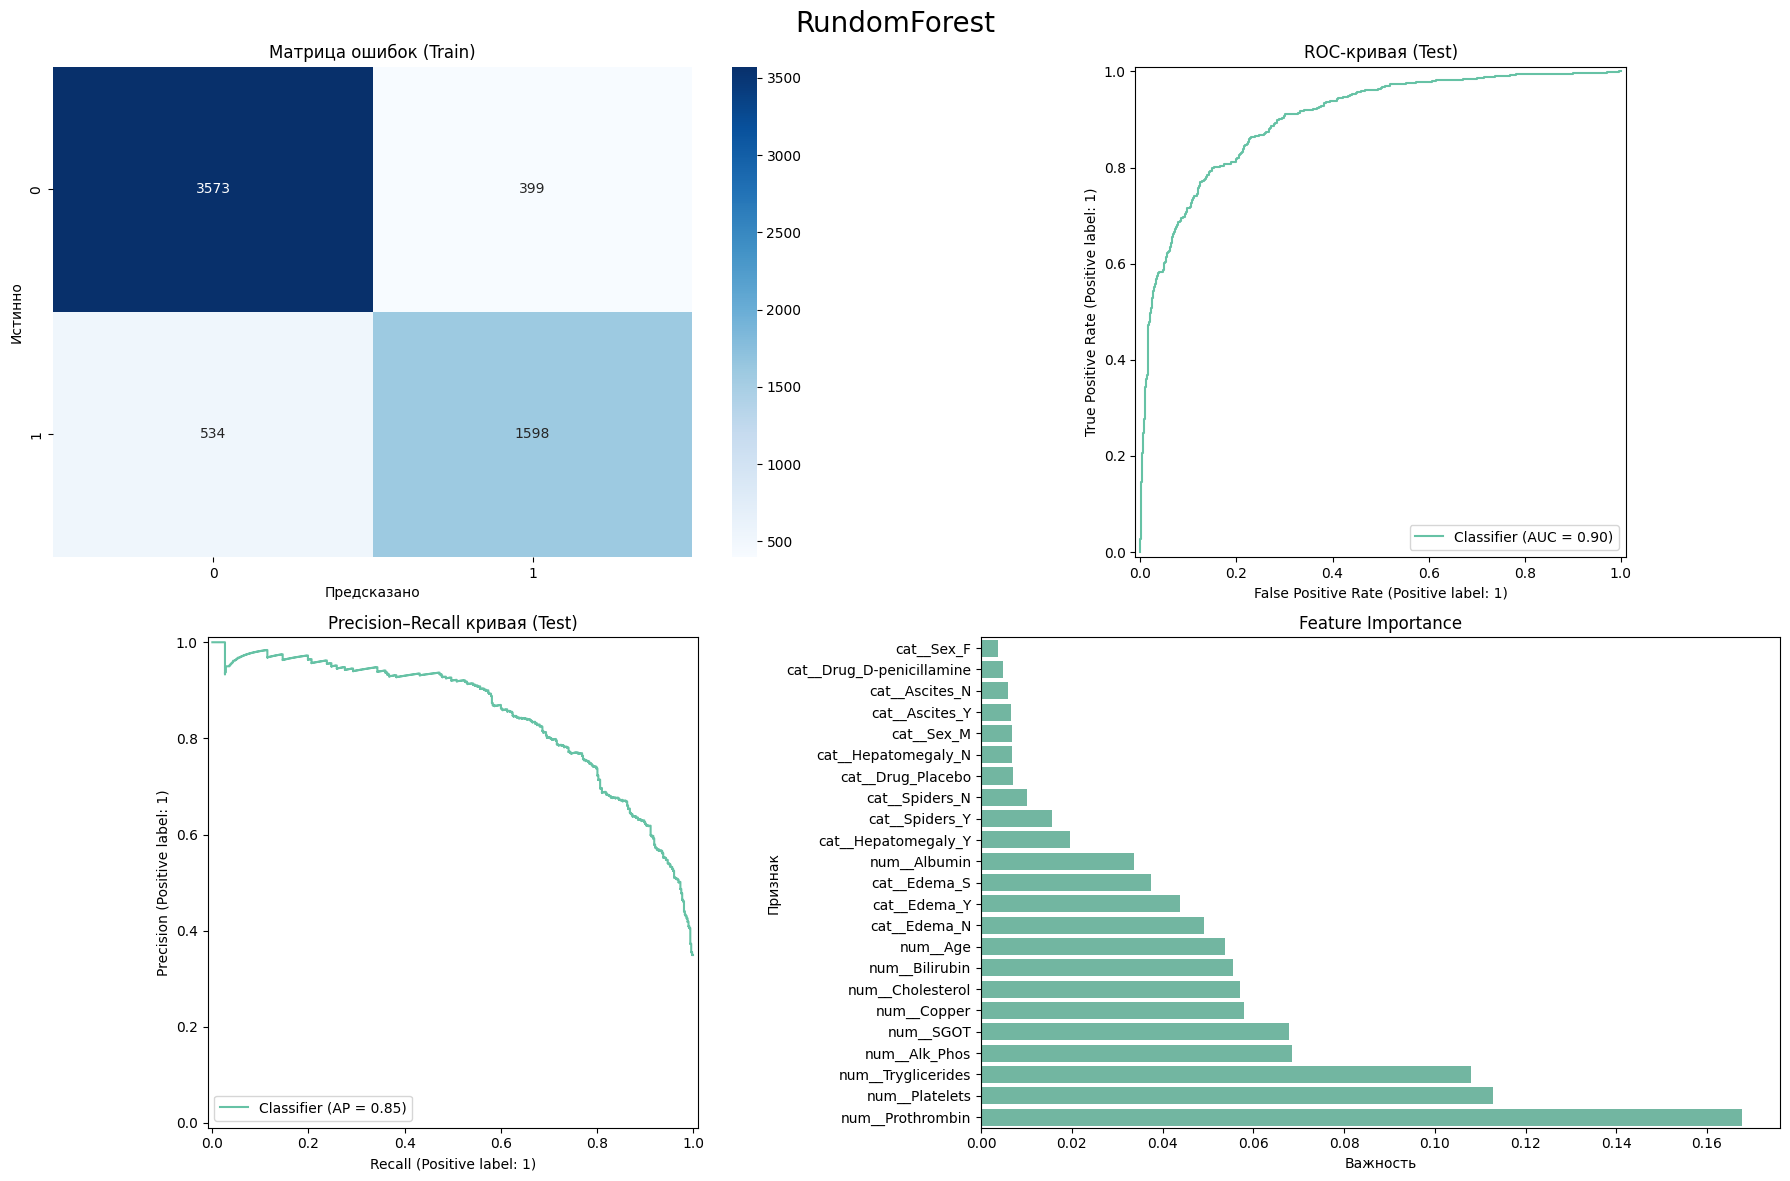

==== ОТЧЁТ НА ====
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       993
           1       0.77      0.74      0.76       533

    accuracy                           0.83      1526
   macro avg       0.82      0.81      0.81      1526
weighted avg       0.83      0.83      0.83      1526



In [420]:
best_model = rf_engineering_dt.best_estimator_
y_train_pred = cross_val_predict(best_model, X_train_fe, y_train, cv=5, n_jobs=-1)

y_test_proba = best_model.predict_proba(X_test_fe)[:, 1]
y_test_pred = best_model.predict(X_test_fe)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("RundomForest", fontsize=20)


cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Матрица ошибок (Train)")
axes[0, 0].set_xlabel("Предсказано")
axes[0, 0].set_ylabel("Истинно")

RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[0, 1], 
)
axes[0, 1].set_title("ROC-кривая (Test)")

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[1, 0],  
)
axes[1, 0].set_title("Precision–Recall кривая (Test)")

model = best_model.named_steps["model"]
importances = model.feature_importances_
features = best_pipeline.named_steps["preprocess"].get_feature_names_out()

features = features[: len(importances)]

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=True)

sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
    ax=axes[1, 1],  
)
axes[1, 1].set_title("Feature Importance")
axes[1, 1].set_xlabel("Важность")
axes[1, 1].set_ylabel("Признак")

plt.tight_layout()
plt.show()

print("==== ОТЧЁТ НА ====")
print(classification_report(y_test, y_test_pred))

## Выводы 

Изменение набора признаков (добавление новых или фильтрация старых) не привело к существенному улучшению или ухудшению качества модели RandomForest.
Модель демонстрирует высокую устойчивость: сохраняет свою предсказательную способность, корректно ранжирует важность признаков и показывает стабильные значения ROC-AUC и PR-AUC.

Это означает, что на данном этапе структура признакового пространства оптимальна, а дальнейшее улучшение качества следует искать не в отборе признаков, а в выборе модели (например, LightGBM/CatBoost) или подборе порога классификации.



## 3. Оптимизация порога классификации

In [421]:
rf_engineering_recall_pipeline = Pipeline(
    [
        (
            "model",
            RandomForestClassifier(random_state=RANDOM_STATE),
        ),
    ]
)

rf_engineering_recall_dt = params_grid_search_recall(rf_engineering_recall_pipeline, 5, X_train_fe, y_train)

Лучшие параметры: {'model__class_weight': {0: 1, 1: 5}, 'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Лучший recall: 0.9235478444437115


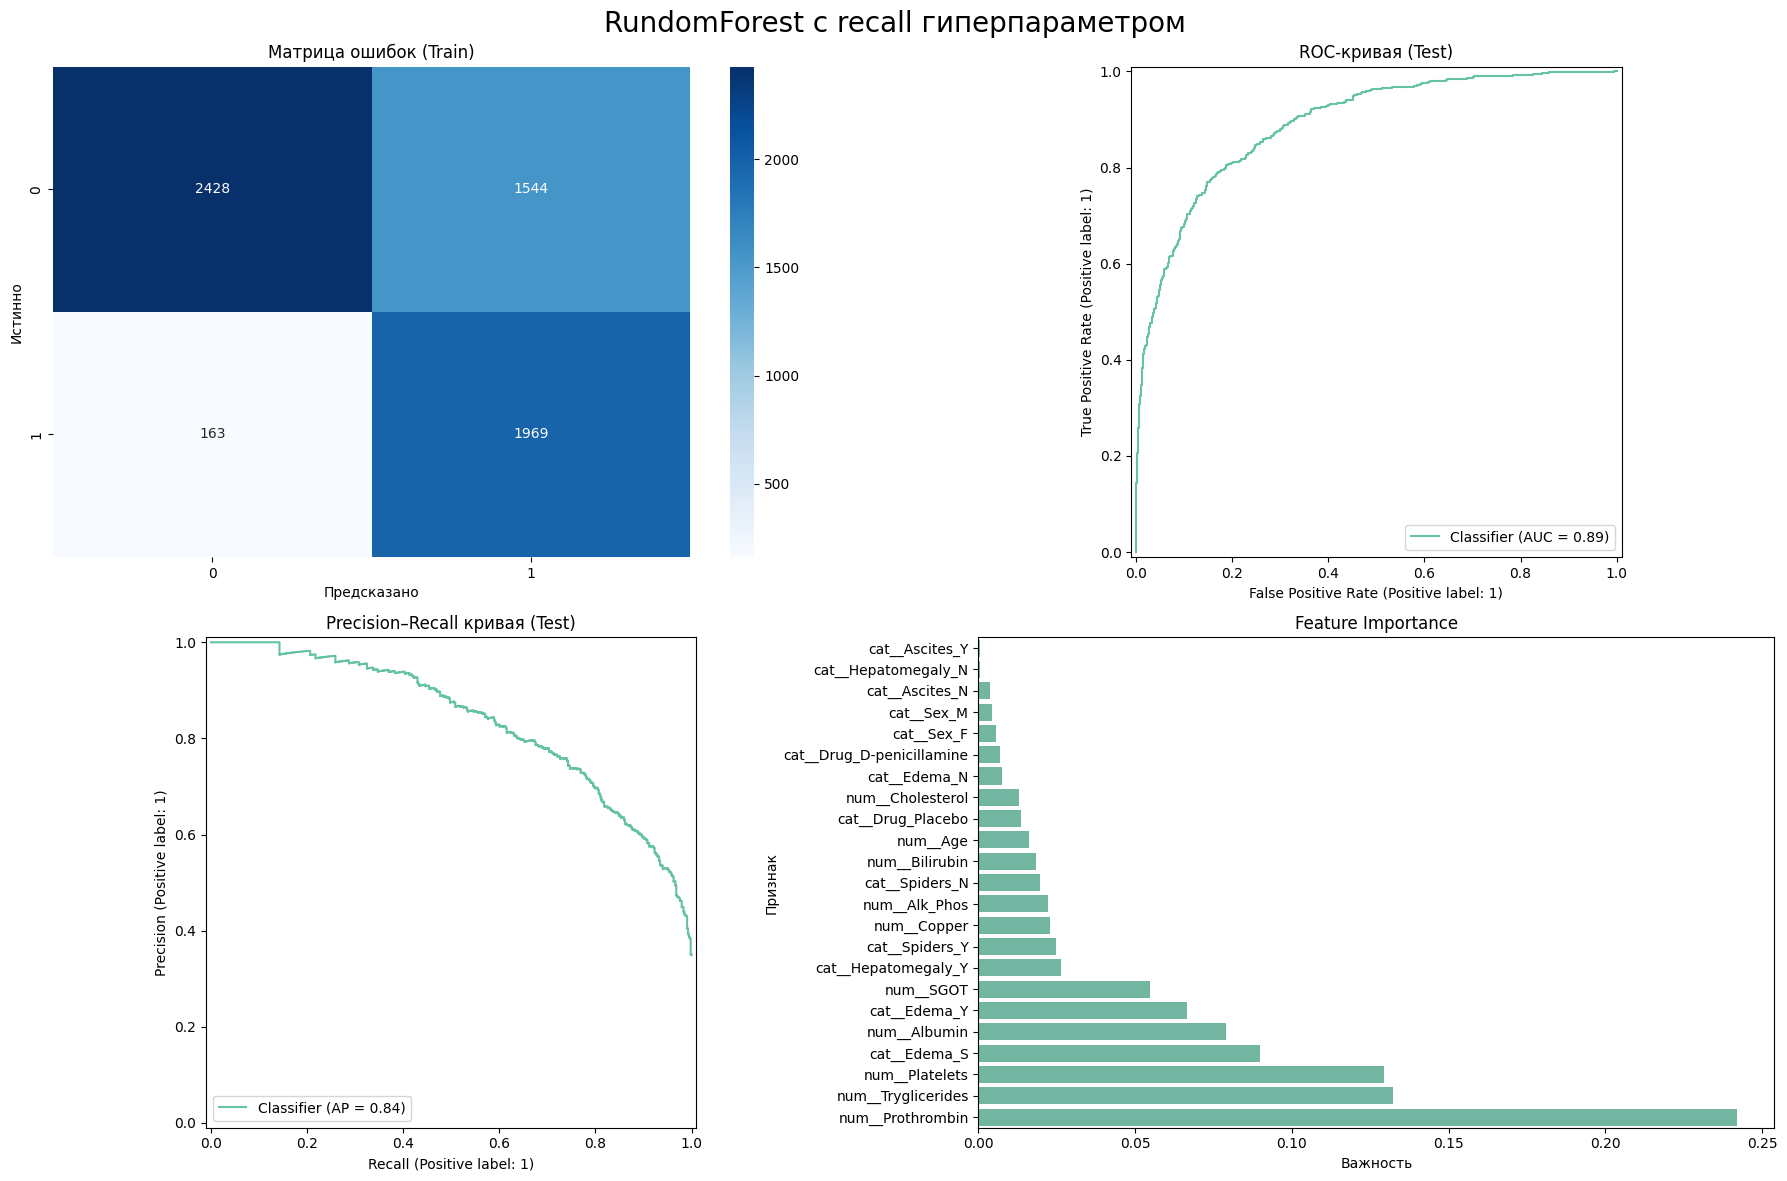

==== ОТЧЁТ НА ====
              precision    recall  f1-score   support

           0       0.94      0.60      0.73       993
           1       0.55      0.93      0.69       533

    accuracy                           0.71      1526
   macro avg       0.75      0.76      0.71      1526
weighted avg       0.81      0.71      0.72      1526



In [424]:
best_model = rf_engineering_recall_dt.best_estimator_
y_train_pred = cross_val_predict(best_model, X_train_fe, y_train, cv=5, n_jobs=-1)

y_test_proba = best_model.predict_proba(X_test_fe)[:, 1]
y_test_pred = best_model.predict(X_test_fe)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("RundomForest с recall гиперпараметром", fontsize=20)


cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Матрица ошибок (Train)")
axes[0, 0].set_xlabel("Предсказано")
axes[0, 0].set_ylabel("Истинно")

RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[0, 1], 
)
axes[0, 1].set_title("ROC-кривая (Test)")

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
    ax=axes[1, 0],  
)
axes[1, 0].set_title("Precision–Recall кривая (Test)")

model = best_model.named_steps["model"]
importances = model.feature_importances_
features = best_pipeline.named_steps["preprocess"].get_feature_names_out()

features = features[: len(importances)]

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=True)

sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
    ax=axes[1, 1],  
)
axes[1, 1].set_title("Feature Importance")
axes[1, 1].set_xlabel("Важность")
axes[1, 1].set_ylabel("Признак")

plt.tight_layout()
plt.show()

print("==== ОТЧЁТ НА ====")
print(classification_report(y_test, y_test_pred))


## Выводы 

Модель с recall-гиперпараметром существенно улучшает полноту класса смерти (Recall = 0.81),
но делает больше ложных срабатываний (Precision = 0.70).

Модель с улучшенными признаками демонстрирует более высокое общее качество:
лучшую точность, лучший ROC-AUC и более низкий уровень ложных тревог.
Однако Recall у неё ниже (0.75), что может быть критично для медицинской задачи.